# Lab 4: Logistic Regression

In this assignment, we will learn the Logistic Regression model.

First, please study the given example, which uses the logistic regression model for the breast cancer classification task. In this example, you will learn how to preprocess data, how to train the model, and how to evaluate the model.

Based on the given example, your task is to use the logistic regression model to predict the presence of heart disease.


## 1. Example

### 1.1 Load the breast cancer data

Here, we use the [breast cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) dataset in sklearn. It is a binary classification dataset. Each sample has 30 numerical features, which can be found in [7.1.7](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from random import shuffle
import random
random.seed(123)

X, y = datasets.load_breast_cancer(return_X_y=True)
print("#samples: {}, #features: {}".format(X.shape[0], X.shape[1]))

#samples: 569, #features: 30


### 1.2 Split the data into two subsets and normalize the features of samples

Here, we use 69 samples as the testing set and use the remained samples to train the logistic regression model. 

In [2]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.12, 
                                                            random_state=0)
print("train_val: {}, test: {}".format(X_train_val.shape[0], X_test.shape[0]))

normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)


train_val: 500, test: 69


### 1.3 Train the logistic regression model and select the hyperparameter with cross-validation

Here, we use the following logistic regression model to do cancer classification. 

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

We need to learn the model parameter $\mathbf{w}$. However, with different hyperparameters $\lambda$, we can get different model parameter $\mathbf{w}$, resulting in different prediction performance. Here, we use the 5-fold cross-validation to select the hyperparameter $\lambda$.

In [3]:
# here we use 5-fold cross-validation
folds = 5

# get the number of samples in the training and validation set
num_train_val = X_train_val.shape[0] 

# shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train_val) 
shuffle(index_of_samples)

# split the index of the train_valid set into 5 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# potential hyperparameters. 
#These hyperparameters are just used for illustration. 
#You should try more hyperparameters to get a good model.
#The hyperparameters must be nonnegative!
regularization_coefficient = [0.1, 0.5, 1.0, 5.0, 10.0]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    
    # 5-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        valid_index = index_of_folds_temp[fold,:].reshape(-1) #get the index of the validation set
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1) #get the index of the training set
        
        # training set
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        
        # validation set
        X_valid = X_train_val[valid_index]
        y_valid = y_train_val[valid_index]
                
        # build the model with different hyperparameters
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #train the model with the training set
        clf.fit(X_train, y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    # store the best hyperparameter
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
        
    


[[380 468 145   2 282 103 148 312 130 411 168 204 113 132 418 270 351 157
  451 339 288 277 354  48 318 303 314 234  95 304 271 434 173 357 495 133
  431  39 490 310 317 471  23 426 224 286  20 365 255 216 405  79 228 445
  189 184 243 358 276 218 488  60 438 159 167 349  89 121 333  51   9 482
  152 416 379 306 111 185 340 489 475  93  84 376 291 158 250 323 406 460
   50 433 372  66 108 465  71 298 369 437]
 [211  11 110 142  28  59 163  38  24 205 440 140 177 252 235 245 242  25
   21 217 160 231  77 151  54 345 280 257 456 308 331  58 360 179 464 388
  129 285 347  56 387 169  36 138 319 296 246 122  33 127 109 363 183 196
  422  86 400 297 346 116  63  88 477 144 112 362 399 334  62 353 146 373
   27  76 260 150 210 195 290  82 154 432 320 361  75  17  94 238 143 469
   67 225 391 106  15  97  46  49 192 226]
 [114 302 356  91  80 107 329 209 384 409  13 176 299 483 295 491 332 292
  153 202 268   1 417 313 375 128 352  57 408 254 382 390 377 328 213 182
   65   7 315 101 187 126 

### 1.4 Evaluate the learned model

After getting the best hyperparameter $\lambda$, we retrain the model with the train_val set. Then, we evaluate this  model on the testing set. 

In [4]:
# retrain the model
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_val, y_train_val)

# evaluate the model on the testing set
y_test_pred = clf.predict(X_test)


acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)


print("accuracy: {:.3f}, recall: {:.3f}, precision: {:.3f}, f1: {:.3f},".format(acc, recall, precision, f1))

accuracy: 1.000, recall: 1.000, precision: 1.000, f1: 1.000,


## 2. Task

Here, we use the [heart disease](./heart.csv) dataset. Each sample has the following feature: 

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

The last column refers to the presence of heart disease in the patient.

The task is to predict whether a person has the heart disease. 

## 2.1 Preprocess the raw data

* Check whether there are missing values
* Check whether theare are cateogrical features
* Check whether this dataset is balanced or not (use the bar plot to visualize the number of positive and negative samples)


In [5]:
import pandas as pd

In [6]:
heart_disease_df = pd.read_csv('heart.csv')

Check if there are missing values:

In [7]:
heart_disease_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

There are no missing values.

Check if there are categorical values:

In [8]:
heart_disease_df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

There are no categorical values.

Check if the dataset is balanced:

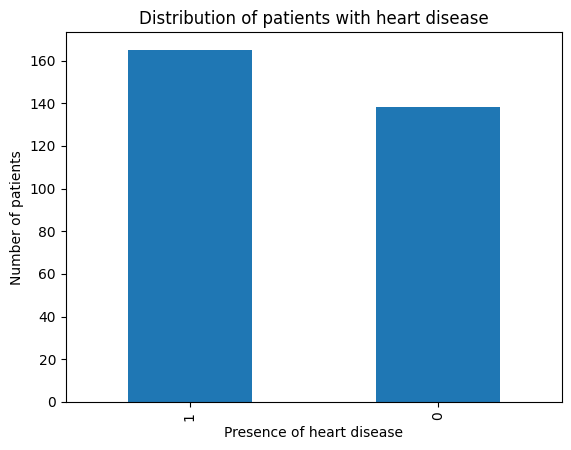

In [9]:
import matplotlib.pyplot as plt

plt.title('Distribution of patients with heart disease')
plt.xlabel('Presence of heart disease')
plt.ylabel('Number of patients')
heart_disease_df['target'].value_counts().plot(kind = 'bar')
plt.show()

The dataset is not balanced.
There are more patients with heart disease than those without heart disease in the dataset.

### 2.2 Split the data into two subsets and normalize the features of samples

* Split the dataset into the train_val set and testing set. 
* Normalize features

These are the possible test sizes for 10-fold cross validation:

In [10]:
possible_test_sizes = [round(1 - x/303, ndigits=4) for x in range(220, 303, 10)]
possible_test_sizes

[0.2739, 0.2409, 0.2079, 0.1749, 0.1419, 0.1089, 0.0759, 0.0429, 0.0099]

I choose 0.2409 as the test size.

In [11]:
heart_disease_features = heart_disease_df.drop('target', axis=1)
heart_disease_target = heart_disease_df['target']
X_train_validation, X_test, y_train_validation, y_test = train_test_split(heart_disease_features.values,
                                                                          heart_disease_target.values,
                                                                          test_size=0.2409,
                                                                          random_state=42)

print(f'samples: {heart_disease_features.shape[0]}, train_val: {X_train_validation.shape[0]}, test: {X_test.shape[0]}')

normalizer = StandardScaler()
X_train_validation = normalizer.fit_transform(X_train_validation)
X_test = normalizer.transform(X_test)

samples: 303, train_val: 230, test: 73


### 2.3 Train the logistic regression model and select the hyperparameter with cross-validation

\begin{equation}
	\min_{\mathbf{w}} \sum_{i=1}^{n}\{\log(1+\exp(\mathbf{w}^T\mathbf{x}_i))-y_i\mathbf{w}^T\mathbf{x}_i \} + \lambda\|\mathbf{w}\|_2^2
\end{equation}

* Use the 10-fold cross-validation to select the hyperparameter $\lambda$.
* Search $\lambda$ from $\{10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 1, 10, 20, 50, 100\}$


In [12]:
# Use 10-fold cross-validation
folds = 10

# Get number of samples in training and validation set
num_train_validation = X_train_validation.shape[0]

# Shuffle index of samples in train_val set
index_of_samples = np.arange(num_train_validation)
shuffle(index_of_samples)

# Split index of train_val set into 10 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

# Hyperparameters to be selected
regularization_coefficient = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100]

best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:

    # 10-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):

        index_of_folds_temp = index_of_folds.copy()

        validation_index = index_of_folds_temp[fold, :].reshape(-1)
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1)

        # Training set
        X_train = X_train_validation[train_index]
        y_train = y_train_validation[train_index]

        # Validation set
        X_validation = X_train_validation[validation_index]
        y_validation = y_train_validation[validation_index]

        # Build the model with current hyperparameter "reg"
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')

        # Train the model with the training set
        clf.fit(X_train, y_train)

        y_validation_pred = clf.predict(X_validation)
        acc = accuracy_score(y_validation, y_validation_pred)

        sum_acc += acc
    
    cur_acc = sum_acc / folds

    print(f'reg_coeff: {1.0 / reg}, acc: {cur_acc:.3f}')

    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg

[[ 59  57 200 100 184 144 162 146 180 153 155 206  65 188 149  31 220 120
   48 207 143  27 137]
 [  5  95 183 111 211  90 127  13 148 163  92 156  55  21 221 202  44  54
   78  62  43  40 124]
 [177 191 212 229 138 104 219   4  19 209 122 189 130  64  69 193 108 185
  195 170 158  71 160]
 [174  53  82  76 101 114  45 135 119 132 131 175 226 147  30 210  39 214
   81 186  42 125  68]
 [ 85 161  70  66 126  79  11 134 205 173 105 168   7 222   9 176 197 141
   77 133  17  12 198]
 [225  24 128 145  86 151 115 116  97   3  93 157   6  99 218  72 123 109
  194 192  49  18 179]
 [ 50 136  26 113 181  47  96  20  75 150 129 152 166  80  89 182 165 213
  106  33 159  94 167]
 [224  67 139 164 154   0 142 223 190  73  63  28  16 140 216 204  58  88
  102 187  83  74   2]
 [172 215  36 196  87 208  60  61 227 112  91  10 228  34  23 178 118  29
   38  14  15 103 169]
 [ 51 110 117  56  37  25   8  84  22 203 201  41   1 217  35 121  32 107
   46  98  52 171 199]]
reg_coeff: 99999.99999999999,

### 2.4 Evaluate the learned model

* Report the prediction accuracy, recall, precision, and F1 score.

* Use the bar plot to visulaize the elements of the learned model parameter vector $\mathbf{w}$. Some elements  have larger absolute values, while the others do not. Try to explain this phenomenon. 

In [13]:
best_reg

1

In [14]:
# Retrain the model
clf = LogisticRegression(penalty='l2', C=best_reg, solver='lbfgs')
clf.fit(X_train_validation, y_train_validation)

# Evaluate model on test set
y_test_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f'accuracy: {acc:.3f}, recall: {recall:.3f}, precision: {precision:.3f}, f1: {f1:.3f}')

accuracy: 0.877, recall: 0.897, precision: 0.875, f1: 0.886


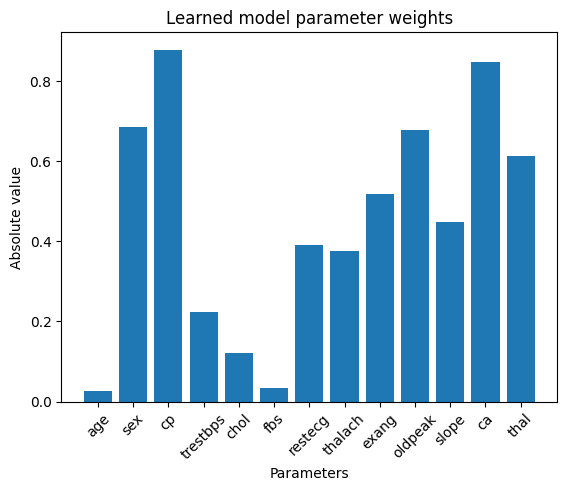

In [15]:
plt.title('Learned model parameter weights')
plt.xlabel('Parameters')
plt.ylabel('Absolute value')
plt.xticks(np.arange(len(heart_disease_features.columns)), heart_disease_features.columns, rotation = 45)
plt.bar(np.arange(len(clf.coef_[0])), np.abs(clf.coef_[0]))
plt.show()

The elements with larger absolute values have a larger affect on the model prediction.
In this case, it appears that `cp`, `ca`, and `sex` are the most influential variables.